<a href="https://colab.research.google.com/github/arguto1993/wordcloud-berita-pusdiklat-bps-2023/blob/main/WordCloud_Berita2600.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import requests

from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Load stopwords

## from nltk library

In [ ]:
nltk.download('stopwords')  # Download if necessary
STOPWORDS = set(nltk.corpus.stopwords.words('english'))  # Load English stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## from files (need to upload the file manually to colab files)

In [ ]:
# Load Indonesian stopwords from the file
# with open("stopwords/stopwords-id.txt", "r") as f:
#     stopwords_id = f.read().splitlines()

# Load Custom stopwords from the file
# with open("stopwords/stopwords-p.txt", "r") as f:
#     stopwords_p = f.read().splitlines()

## from google drive (recommended)

In [ ]:
def download_file_from_drive(file_id, filename):
    """Downloads a file from Google Drive using its ID and saves it to a specified filename."""
    url = f"https://drive.google.com/uc?id={file_id}&export=download"
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
            print(f"Success: {filename} downloaded from Google Drive.")
        return True
    else:
        print(f"Error: Failed to download {filename} from Google Drive.")
        return False

# Download stopwords-id.txt
if download_file_from_drive("1EyhKHCCAJOHBA_iicz4ry-VLcu3RmXZE", "stopwords/stopwords-id.txt"):
    with open("stopwords/stopwords-id.txt", "r") as f:
        stopwords_id = f.read().splitlines()

# Download stopwords-p.txt
if download_file_from_drive("12ZjGx05K3FfSeKPyMYhhalrldZHR6Zaz", "stopwords/stopwords-p.txt"):
    with open("stopwords/stopwords-p.txt", "r") as f:
        stopwords_p = f.read().splitlines()

Success: stopwords/stopwords-id.txt downloaded from Google Drive.
Success: stopwords/stopwords-p.txt downloaded from Google Drive.


# Combine stopwords

In [ ]:
# Combine default and custom stopwords
stopwords_c = set(STOPWORDS).union(stopwords_id).union(stopwords_p)  # Use a set for efficient membership testing
# stopwords_c = stopwords_p

# Load clean dataset (cleaned via [spreadsheets](https://docs.google.com/spreadsheets/d/13hsXm20S6RdAyK520rLLkbbUJEywRp5F/edit?usp=sharing&ouid=101051388151123974532&rtpof=true&sd=true))

## Load spreatsheet to DataFrame

In [ ]:
# Google drive file id for clean dataset
file_id = "13hsXm20S6RdAyK520rLLkbbUJEywRp5F"
# Construct the download URL
GSHEET_URL_XLSX = f"https://drive.google.com/uc?id={file_id}&export=download"

# Download the file using requests
response = requests.get(GSHEET_URL_XLSX, stream=True)

with open("data/berita2600konten.xlsx", 'wb') as f:
    try:
        # for chunk in response.iter_content(chunk_size=2048):
        for chunk in response.iter_content(chunk_size=4048):
            f.write(chunk)
        print("Data download and writing complete!")
    except Exception as e:
        print("An error occurred during download:", e)

# Read the Excel file using the specified engine
data = pd.read_excel("data/berita2600konten.xlsx", sheet_name="data_c3")
print("DataFrame ready")

Data download and writing complete!
DataFrame ready


## Number of contents

In [ ]:
num_content = data["konten_clean"].shape[0]  # skip header
print(f"Number of contents: {num_content:,}")

Number of contents: 184


## Display cleaned contents

In [ ]:
pd.options.display.max_colwidth = 400  # Set a larger width for full display
data["konten_clean"].head()

,konten_clean
0,Rapat Koordinasi Pusdiklat BPS dan Universitas Negeri Jakarta Senin (18/12) Pusdiklat BPS menerima kunjungan Tim Pengelola Jurnal Statistika dan Aplikasinya (JSA) dari Program Studi Statistika Universitas Negeri Jakarta (UNJ). Dalam sambutannya Koordinator Prodi Statistika Dr. Dian Handayani menyampaikan bahwa JSA yang telah berdiri sejak tahun 2017 menargetkan pada tahun 2024 menjadi jurnal ...
1,Penutupan Study Visit GSO Vietnam di Pusdiklat BPS Jakarta – Pada Kamis (14/12) General Statistics Office (GSO) Vietnam telah mengikuti serangkaian kegiatan studi visit di Pusdiklat BPS. Sebelum melanjutkan kegiatannya di BPS tim GSO Vietnam dan Pusdiklat BPS duduk bersama di Hotel Mercure Sabang menyampaikan kesan pesan selama kegiatan. Nguyen Thanh Duong selaku Deputy Director General of GS...
2,Kolaborasi dan Komunikasi Kunci Sukses Pembinaan Statistik Sektoral Jakarta – Hari terakhir Pelatihan Pembina Statistik Sektoral mengusung tema besar “Public Speaking” sebagai bekal bagi para Pembina Statistik Sektoral. Narasumber handal yang hadir mampu menggugah dan mengajak para peserta untuk mengubah mindset para Pembina Statistik Sektoral menuju sukses kolaborasi dan komunikasi. Rabu (13...
3,Workshop Penyusunan Kurikulum dan Modul Pelatihan Jakarta – Untuk menunjang penyelenggaraan Jabatan Fungsional Statistisi (JFS) Pusdiklat BPS menyelenggarakan kegiatan Workshop Penyusunan Kurikulum dan Modul Pelatihan yang akan berlangsung di Hotel Mercure Jakarta Sabang pada 13 – 16 Desember 2023. Workshop ini merupakan kolaborasi Pusdiklat BPS dengan Subject Matter BPS RI serta Tim Jabatan ...
4,Pembukaan Pembinaan Statistik Sektoral Tematik Neraca Ekonomi Lingkungan 2023 Pusdiklat BPS berkolaborasi dengan Direktorat Neraca Produksi menyelenggarakan Pembinaan Statistik Sektoral Tematik Neraca Ekonomi Lingkungan 2023 diawali dengan overviu kebijakan pelatihan pada Jumat (8/12) dan pembelajaran jarak jauh (PJJ) pada 12-15 Desember 2023. Peserta pelatihan berjumlah 81 peserta yang melip...


In [ ]:
# Clean text (adjust as needed)
clean_text = (
    data["konten_clean"]
        # .str.lower()
        .str.replace(r"\n", " ")  # Remove newlines
        .str.replace(r"<[^>]*>", " ")  # Remove HTML tags
        .str.replace(r"\/.,", " ")  # Remove punctuation (adjust as needed)
)  # Apply cleaning to each row

# Tokenize text
nltk.download('punkt_tab')
words_per_row = clean_text.apply(word_tokenize)  # Tokenize each row

# Count words in each row and sum across the DataFrame
num_words = words_per_row.apply(len).sum()
print(f"Number of words (using nltk): {num_words:,}")

# List of words
list_words = words_per_row.sum()  # Sum the word counts in each row
# Print only first 50 words to avoid GitHub rendering issues
print(f"List of words (using nltk) - showing first 10: {list_words[:10]}")
print(f"Total unique words in list: {len(list_words):,}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Number of words (using nltk): 34,623
List of words (using nltk) - showing first 10: ['Rapat', 'Koordinasi', 'Pusdiklat', 'BPS', 'dan', 'Universitas', 'Negeri', 'Jakarta', 'Senin', '(']
Total unique words in list: 34,623


# Generate Word Cloud

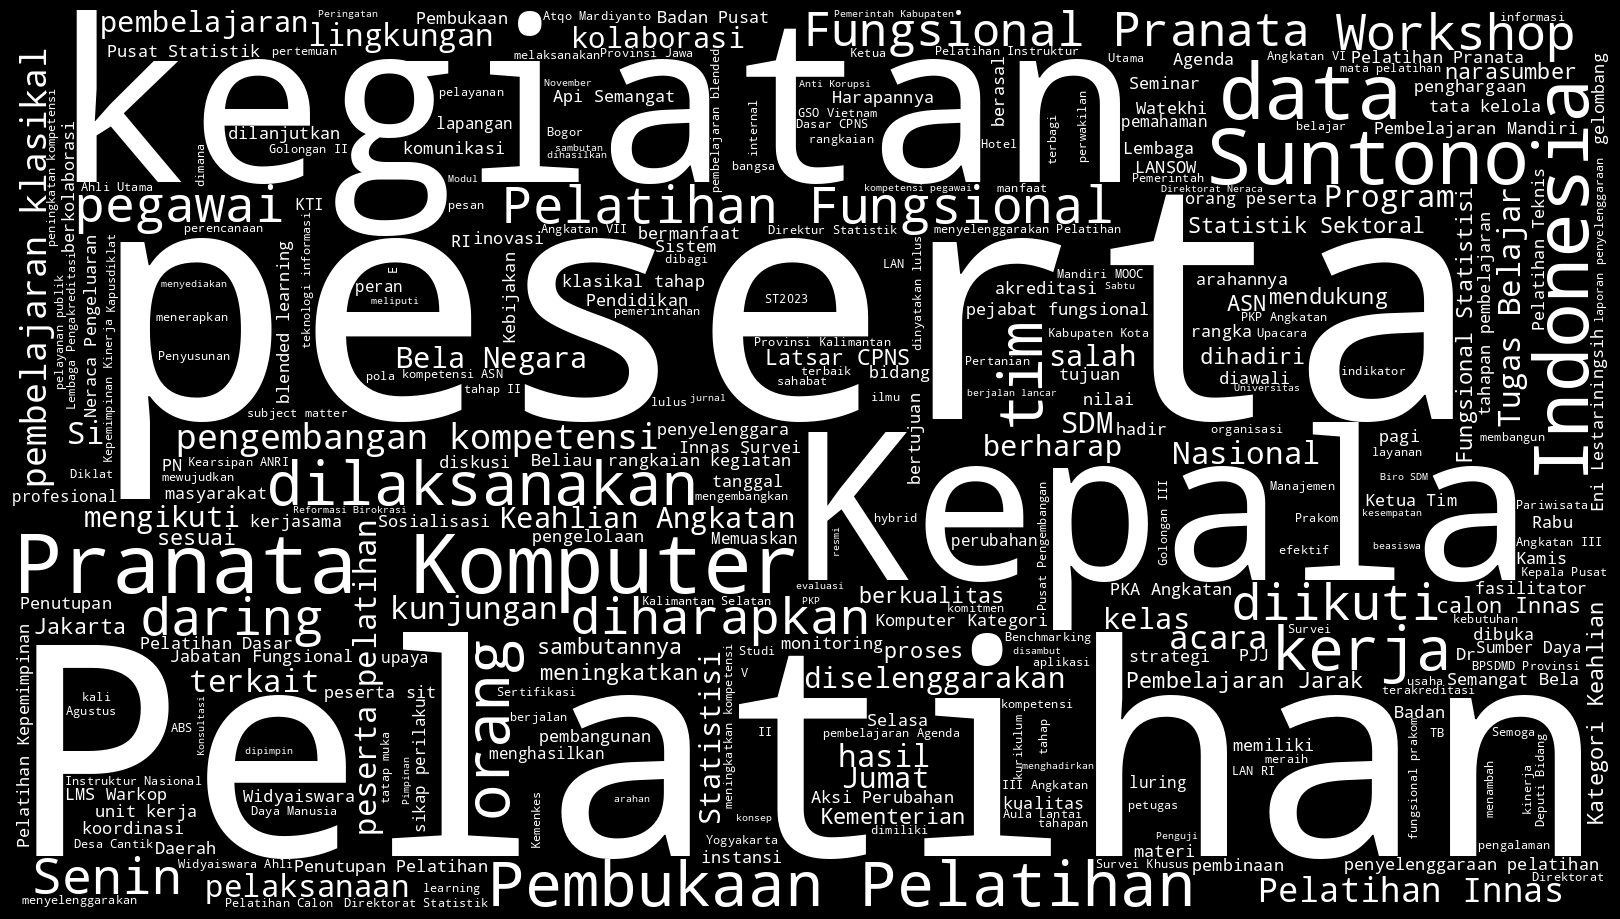

In [ ]:
# Function to set text color to white
def white_color_func(word, font_size, position, orientation, random_state=26, **kwargs):
    return "white"

clean_text_string = data["konten_clean"].str.cat(sep=" ")

# Tokenize the text using nltk
words = word_tokenize(clean_text_string)

# Join the tokenized words into a string
word_string = " ".join(words)

# Generate word cloud with nltk-tokenized text
wordcloud = WordCloud(
    background_color="black",
    max_words=4000,
    stopwords=stopwords_c,
    width=1600,
    height=900,
    color_func=white_color_func,
    relative_scaling=0.5,
    min_font_size=10,
).generate(word_string)

# Display the word cloud
fig, ax = plt.subplots(figsize=(16, 9), facecolor='black')
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# Optionally save the word cloud as an image
# wordcloud.to_file("wordcloud_berita2600_2023.png")

# Generate Charts

## Load DataFrame

In [ ]:
# Access raw word frequencies from the generated word cloud
word_counts = wordcloud.process_text(clean_text_string)

# Create a DataFrame of word frequencies
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['freq'])

# Sort by word count in descending order
word_counts_df = word_counts_df.sort_values(by='freq', ascending=False)

# Print the top 10 words and their frequencies
n=10
print(word_counts_df.head(n))

# Optionally, save the DataFrame to a CSV file
# word_counts_df.to_csv(f"top_{n}_words.csv", index=False)

                     freq
peserta               241
Pelatihan             213
kegiatan              154
Kepala                137
Pranata Komputer       91
data                   79
Suntono                78
Indonesia              73
Pembukaan Pelatihan    67
tim                    65


In [ ]:
# Access the words and frequencies from the generated word cloud
words_and_frequencies = wordcloud.words_

# Count unique words, excluding stopwords
unique_word_count = 0
for word, frequency in words_and_frequencies.items():
    if word not in stopwords_c:  # Check if not a stopword
        unique_word_count += 1

print(f"Number of unique words (excluding stopwords): {unique_word_count:,}")

Number of unique words (excluding stopwords): 3,615


In [ ]:
word_counts_df

,freq
peserta,241
Pelatihan,213
kegiatan,154
Kepala,137
Pranata Komputer,91
...,...
menegakkan,1
kebenaran,1
keadilan,1
menawarkan,1


In [18]:
total_frequency = word_counts_df['freq'].sum()  # Sum all frequencies in the 'freq' column
print(f"Total frequency of all words & phrases: {total_frequency:,}")
print(f"Average number of all words & phrases per post: {total_frequency/num_content:.2f}")

Total frequency of all words & phrases: 15,333
Average number of all words & phrases per post: 83.33


## Pie Chart

/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:3333: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = np.asarray(x, np.float32)


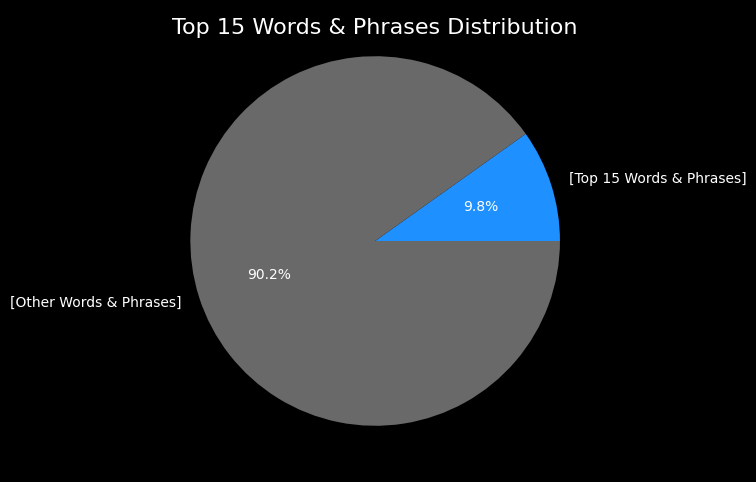

In [ ]:
plt.style.use('dark_background')

# Select top n words and aggregate others into "others" category
n = 15
top_n_words = word_counts_df.head(n)
other_words = word_counts_df.tail(-15).sum()

# Combine top n words into a single "Top 15 Words" category
top_n_words = top_n_words.sum().rename(f"Top {n} Words")

# Create a DataFrame with the two desired categories
pie_data = pd.DataFrame({'freq': [top_n_words, other_words]}, index=[f'[Top {n} Words & Phrases]', '[Other Words & Phrases]'])

# Create pie chart with blue and light gray colors
colors = ['dodgerblue', 'dimgrey']  # Define the color palette
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(pie_data['freq'], labels=pie_data.index, autopct="%1.1f%%", colors=colors)

# Increase font size for all elements
plt.rcParams['font.size'] = 10  # Set overall font size for text elements

# Adjust title position and font size
plt.title(f"Top {n} Words & Phrases Distribution", y=0.93, fontsize=16)
plt.show()


## Horizontal Bar Chart



<Figure size 1600x900 with 0 Axes>

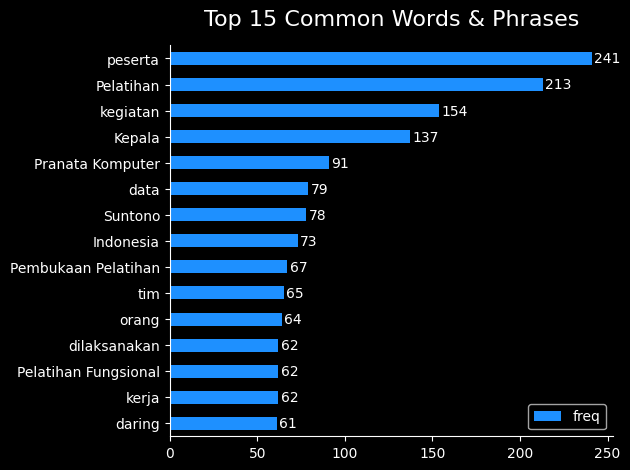

In [ ]:
# Get the top n most common words
n=15
top_n_words = word_counts_df.head(n)

# Create horizontal bar chart with reversed y-axis
plt.figure(figsize=(16, 9))
ax = top_n_words.plot(kind='barh', color='dodgerblue')  # Set bar color to blue
ax.invert_yaxis()

# Add data labels at the end of each bar
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width() + 1.4, p.get_y() + p.get_height() / 1.2))

plt.rcParams['font.size'] = 10  # Set overall font size for text elements
plt.title(f"Top {n} Common Words & Phrases", y=1.03, fontsize=16)
plt.tight_layout()

# Remove top and right lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks from top and right axes
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Show the chart
plt.draw()
plt.show()
